In [11]:
import numpy as np
#import pyaudio
import time
import essentia

import matplotlib.pyplot as plt
%matplotlib inline


# Learn to map sound to notes

1. Take professional music sound files
2. Play, logging spectrum (frequency / time) and other attributes
    a. https://github.com/tyiannak/pyAudioAnalysis/wiki/3.-Feature-Extraction, OR
    b. 
3. Predict notes based on sound
    a. input spectrum is the "X"
    b. sheet music notes are the "y" (notes A, B, C, etc.)

In [2]:
# first, we need to import our essentia module. It is aptly named 'essentia'!

import essentia

# as there are 2 operating modes in essentia which have the same algorithms,
# these latter are dispatched into 2 submodules:

import essentia.standard
import essentia.streaming

# let's have a look at what is in there

print dir(essentia.standard)

# you can also do it by using autocompletion in IPython, typing "essentia.standard." and pressing Tab


['AfterMaxToBeforeMaxEnergyRatio', 'AllPass', 'AudioLoader', 'AudioOnsetsMarker', 'AudioWriter', 'AutoCorrelation', 'BPF', 'BandPass', 'BandReject', 'BarkBands', 'BeatTrackerDegara', 'BeatTrackerMultiFeature', 'Beatogram', 'BeatsLoudness', 'BinaryOperator', 'BinaryOperatorStream', 'BpmHistogramDescriptors', 'BpmRubato', 'CartesianToPolar', 'CentralMoments', 'Centroid', 'ChordsDescriptors', 'ChordsDetection', 'ChordsDetectionBeats', 'Clipper', 'Crest', 'CrossCorrelation', 'CubicSpline', 'DCRemoval', 'DCT', 'Danceability', 'Decrease', 'Derivative', 'DerivativeSFX', 'Dissonance', 'DistributionShape', 'Duration', 'DynamicComplexity', 'ERBBands', 'EasyLoader', 'EffectiveDuration', 'Energy', 'EnergyBand', 'EnergyBandRatio', 'Entropy', 'Envelope', 'EqloudLoader', 'EqualLoudness', 'Extractor', 'FFT', 'FadeDetection', 'Flatness', 'FlatnessDB', 'FlatnessSFX', 'Flux', 'FrameCutter', 'FrameGenerator', 'FrameToReal', 'FrequencyBands', 'GFCC', 'GeometricMean', 'HFC', 'HPCP', 'HarmonicBpm', 'Harmonic

In [3]:
# Essentia has a selection of audio loaders:
#
#  - AudioLoader: the basic one, returns the audio samples, sampling rate and number of channels
#  - MonoLoader: which returns audio, down-mixed and resampled to a given sampling rate
#  - EasyLoader: a MonoLoader which can optionally trim start/end slices and rescale according
#                to a ReplayGain value
#  - EqloudLoader: an EasyLoader that applies an equal-loudness filtering on the audio
#

# we start by instantiating the audio loader:
loader = essentia.standard.MonoLoader(filename = 'ave.mp3')

# and then we actually perform the loading:
audio = loader()

# by default, the MonoLoader will output audio with 44100Hz samplerate


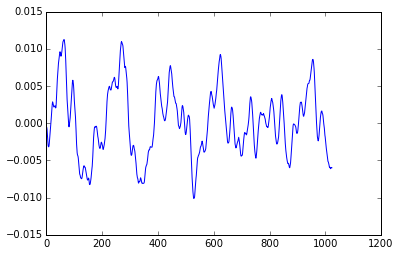

In [20]:
# pylab contains the plot() function, as well as figure, etc... (same names as Matlab)
from pylab import plot, show, figure

plot(audio[5*44100:5*44100 + 1024])
#show() # unnecessary if you started "ipython --pylab"

In [8]:
from essentia.standard import *
w = Windowing(type = 'hann')
spectrum = Spectrum()  
mfcc = MFCC()

# let's have a look at the inline help:
help(MFCC)

# you can also see it by typing "MFCC?" in IPython


Help on class Algo in module essentia.standard:

class Algo(Algorithm)
 |  MFCC
 |  
 |  
 |  Inputs:
 |  
 |    [vector_real] spectrum - the audio spectrum
 |  
 |  
 |  Outputs:
 |  
 |    [vector_real] bands - the energies in mel bands
 |    [vector_real] mfcc - the mel frequency cepstrum coefficients
 |  
 |  
 |  Parameters:
 |  
 |    highFrequencyBound:
 |      real ∈ (0,inf) (default = 11000)
 |      the upper bound of the frequency range [Hz]
 |  
 |    inputSize:
 |      integer ∈ (1,inf) (default = 1025)
 |      the size of input spectrum
 |  
 |    lowFrequencyBound:
 |      real ∈ [0,inf) (default = 0)
 |      the lower bound of the frequency range [Hz]
 |  
 |    numberBands:
 |      integer ∈ [1,inf) (default = 40)
 |      the number of mel-bands in the filter
 |  
 |    numberCoefficients:
 |      integer ∈ [1,inf) (default = 13)
 |      the number of output mel coefficients
 |  
 |    sampleRate:
 |      real ∈ (0,inf) (default = 44100)
 |      the sampling rate of the

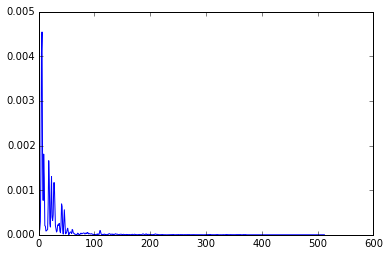

In [9]:
frame = audio[5*44100 : 5*44100 + 1024]
spec = spectrum(w(frame))

plot(spec)
#show() # unnecessary if you started "ipython --pylab"

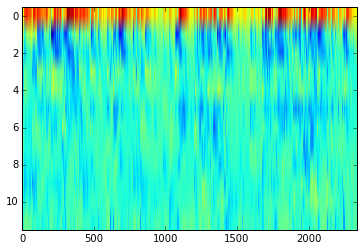

In [14]:
mfccs = []

for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
    mfccs.append(mfcc_coeffs)

# transpose to have it in a better shape
# we need to convert the list to an essentia.array first (== numpy.array of floats)
mfccs = essentia.array(mfccs).T

# and plot
plt.imshow(mfccs[1:,:], aspect = 'auto')
# We ignored the first MFCC coefficient to disregard the power of the signal and only plot its spectral shape


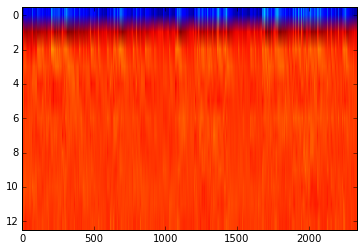

In [15]:
plt.imshow(mfccs[:,:], aspect = 'auto')

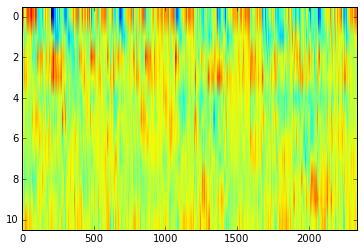

In [16]:
plt.imshow(mfccs[2:,:], aspect = 'auto')

In [17]:
# FFT() would return the complex FFT, here we just want the magnitude spectrum
fft = FFT()  

/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


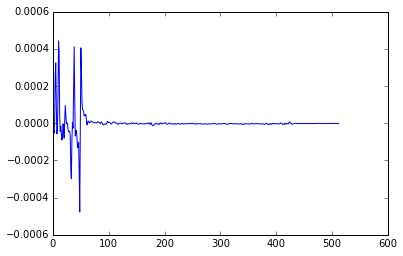

In [18]:
fftb = fft(w(frame))

plot(fftb)

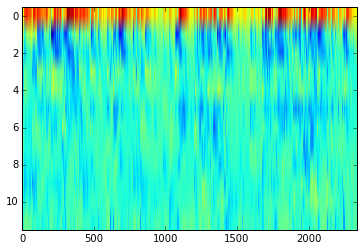

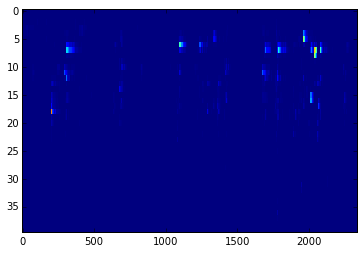

In [22]:
pool = essentia.Pool()

for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
    pool.add('lowlevel.mfcc', mfcc_coeffs)
    pool.add('lowlevel.mfcc_bands', mfcc_bands)

plt.imshow(pool['lowlevel.mfcc'].T[1:,:], aspect = 'auto')
#show() # unnecessary if you started "ipython --pylab"
figure()
plt.imshow(pool['lowlevel.mfcc_bands'].T, aspect = 'auto', interpolation = 'nearest')

# Stream processing


In [23]:
import essentia
from essentia.streaming import *

In [24]:
# and instantiate our algorithms

loader = MonoLoader(filename = 'ave.mp3')
frameCutter = FrameCutter(frameSize = 1024, hopSize = 512)
w = Windowing(type = 'hann')
spec = Spectrum()
mfcc = MFCC()


In [25]:
# In streaming, instead of calling algorithms like functions, we need to
# connect their inputs and outputs. This is done using the >> operator
#
# The graph we want to connect looks like this:
#  ____________       _________________       ________________       __________________
# /            \     /                 \     /                \     /                  \
# | MonoLoader |     |   FrameCutter   |     |   Windowing    |     |     Spectrum     |
# |            |     |                 |     |                |     |                  |
# |     audio -+-->--+- signal  frame -+-->--+- frame  frame -+-->--+- frame spectrum -+-->-\
# \____________/     \_________________/     \________________/     \__________________/    |
#                                                                                           |
#  /----------------------------------------------------------------------------------------/
#  |    ___________________
#  |   /                   \
#  |   |      MFCC         |
#  |   |            bands -+-->-- ???
#  \->-+- spectrum         |
#      |             mfcc -+-->-- ???
#      \___________________/
#

loader.audio >> frameCutter.signal
frameCutter.frame >> w.frame >> spec.frame
spec.spectrum >> mfcc.spectrum


<essentia.streaming._StreamConnector instance at 0x117889638>

In [26]:
# When building a network, all inputs need to be connected, no matter what, otherwise the network
# cannot be started

essentia.run(loader)


RuntimeError: MFCC::bands is not connected to any sink...

In [27]:
#  ____________       _________________       ________________       __________________
# /            \     /                 \     /                \     /                  \
# | MonoLoader |     |   FrameCutter   |     |   Windowing    |     |     Spectrum     |
# |            |     |                 |     |                |     |                  |
# |     audio -+-->--+- signal  frame -+-->--+- frame  frame -+-->--+- frame spectrum -+-->-\
# \____________/     \_________________/     \________________/     \__________________/    |
#                                                                                           |
#  /----------------------------------------------------------------------------------------/
#  |    ___________________              _________
#  |   /                   \            /         \
#  |   |      MFCC         |      /-->--+ NOWHERE |
#  |   |            bands -+-->--/      \_________/
#  \->-+- spectrum         |
#      |             mfcc -+-->--\       _____________________
#      \___________________/      \     /                     \
#                                  -->--+ Pool: lowlevel.mfcc |
#                                       \_____________________/

pool = essentia.Pool()

mfcc.bands >> None
mfcc.mfcc >> (pool, 'lowlevel.mfcc')

essentia.run(loader)

print 'Pool contains %d frames of MFCCs' % len(pool['lowlevel.mfcc'])


Pool contains 2337 frames of MFCCs


In [28]:
# Let's try writing directly to a text file, no pool and no yaml files

# we first need to disconnect the old connection to the pool to avoid putting the same
# data in there again
mfcc.mfcc.disconnect((pool, 'lowlevel.mfcc'))

# we create a FileOutput
fileout = FileOutput(filename = 'mfccframes.txt')

# and connect it: it is a special connection as it has no input, because it can actually
# take any type of input (the other algorithms will complain if you try to connect an output
# to an input of a different type)
mfcc.mfcc >> fileout

# reset the network otherwise the loader in particular will not do anything useful
essentia.reset(loader)

# and rerun it!
essentia.run(loader)



# Music 21

In [33]:
from music21 import *

In [34]:
converter.parse("tinynotation: 3/4 c4 d8 f g16 a g f#").show()

SubConverterException: Cannot find a path to the 'mscore' file at /Applications/MuseScore 2.app/Contents/MacOS/mscore -- download MuseScore

# V1: Download piano train / test data

You'll need to request access at: http://www.tsi.telecom-paristech.fr/aao/en/2010/07/08/maps-database-a-piano-database-for-multipitch-estimation-and-automatic-transcription-of-music/. It takes a day or so to get credentials. As there are some peculularities about how to down load the data, the best bet is to use Filezilla (https://filezilla-project.org/). Ensure your "Host" protocl prefix is "fpes://". 


# V1: Generate harp note / chord train / test files

Garageband or other to generate:
1. individual instrument note (pitch?), chord by major/minor, octave, inversion
2. sequence files w/ varying amounts of spacing
3. mp3's of classical music for which you can easily veryify the notes


# V2: Standard: Fingerprint music files

In [ ]:
# use FFT, MFCC, etc to create a fignerprint of each of the music files s/t when user starts playing, you can take notes they've played and match 

# V2: Streaming: Extract note Sample

# V2: Streaming: Search / match sample to fingerprints

# Establish stream

Use pyaudio to instantiate stream for practice session

In [ ]:
WIDTH = 2
CHANNELS = 2
RATE = 44100

p = pyaudio.PyAudio()

def callback(in_data, frame_count, time_info, status):
    return (in_data, pyaudio.paContinue)

stream = p.open(format=p.get_format_from_width(WIDTH),
                channels=CHANNELS,
                rate=RATE,
                input=True,
                output=True,
                stream_callback=callback)

stream.start_stream()

while stream.is_active():
    time.sleep(0.1)

stream.stop_stream()
stream.close()

p.terminate()

# Display mode

1. Accept song selection
2. Load / display sheet music
3. Listen for start
4. Recieve sounds / translate notes
5. Track progress w/ vertical bar
6. Spot repeats re-setting tracking bar

In [ ]:
# https://github.com/tyiannak/pyAudioAnalysis
# http://essentia.upf.edu/documentation/


# Evaluate mode

1. display mode functionality including tracking progress
2. record playing. overlay repeats. you're tracking stats. so, obj s/b:
    a. to get through song re-playing pieces as required, THEN
    b. to get through song cleanly
3. comparing played to professional
    a. option to play:
        i. metrinome 
        ii. professional a low volume
4. identify discrpancies (timing after prior note, incorrect note)
    a. Gaia, a C++ library with python bindings which implement similarity measures and classification on the results of audio analysis, and generate classification models that Essentia can use to compute high-level description of music.
5. show discrepancies
    a. accept tolerances (+/- time, other?)
    b. show played note in red (i.e., before/after, above/below).
6. show / log statistics
    a. accuracy
    b. similarity
    c. error types and frequency distribution
        i. early,
        ii. late
        iii. wrong note
    d. problem areas

# Interactive mode

1. evaluate mode functionality
2. prompt session info and imprint voice of user for command interface
    a. "this is []. the date is []. i'll be practicing for about [] minutes."
3. voice commands
    a. "replay [] notes" - defaults to: 5 notes, played version
    b. "replay base [] notes"
    c. "loop [] notes" - 
        ii. Loop [] notes / Stop Loop
2. 

# References

This project would not be possible without the invaluable assistance of:

## Training data

The MAPS piano data set. Roughly 40G of piano notes, chords, music assembled by V. Emiya for her PhD thesis at Telecom ParisTech/ENST in 2008 and in conjunction with R. Badeau, B. David for their paper "Multipitch estimation of piano sounds using a new probabilistic spectral smoothness principle"<cite data-cite="emiya2010multipitch"></cite>


In [ ]:
# for installing latex, bibtex and pdf-ing jupyter notenooks: https://www.youtube.com/watch?v=m3o1KXA1Rjk